In [27]:
import numpy as np
import pandas as pd
from credit import Credit

Definimos las variables

In [38]:
# Leer factores de descuento
with open('df.txt', 'r') as archivo:
    discount_factors = archivo.read()
    discount_factors = discount_factors.split(',')
    for i in range(len(discount_factors)):
        discount_factors[i] = float(discount_factors[i])
    P = np.array(discount_factors)

In [41]:
N = 12 # Número de meses
r = np.zeros([N+1, N+1]) # Arbol Binomial
Q = np.zeros([N+1, N+1]) # Precios Arrow-Debreu
theta = np.zeros(N+1) # Drift
dt = 1/12 # Delta t
sigma = 0.0016835430755297832 # Volatilidad

In [42]:
r[0][0] = 0.04761 # Tasa inicial
Q[0][0] = 1 # Precio inicial


theta[0] = ((-(2*P[1]-1)+np.sqrt(1 + 4 * P[1]**2 * dt**3 * sigma**2) )/ (2*P[1]*dt) - r[0][0])/dt

Tasas nivel 1

In [43]:
r[1][1] = r[0][0] + theta[0]*dt + sigma*np.sqrt(dt)
r[0][1] = r[0][0] + theta[0]*dt - sigma*np.sqrt(dt)

Funciones para despejar theta

In [44]:
# Factor de descuento
def disc_factor(r: float, dt: float)->float:
    return 1 / (1 + dt*r)

def ab_ident(theta: float, j: int, P: list, Q : list, r: list, dt: float, sigma: float)->float:

    s = sigma * np.sqrt(dt)
    
    value = 0.5 * Q[0][j] * disc_factor(r[0][j] + theta*dt - s, dt)
    value += 0.5 * Q[j][j] * disc_factor(r[j][j] + theta*dt + s, dt)

    middle_nodes = [(Q[i-1][j] + Q[i][j])*disc_factor(r[i][j] + theta*dt, dt) for i in range(1, j+1)] # -s
    value += 0.5 * sum(middle_nodes)
    value -= P[j+1]

    return value
    
def ab_ident_deriv(theta: float, j: int, P: list, Q : list, r: list, dt: float, sigma: float)->float:
    s = sigma * np.sqrt(dt)
    value = (-0.5) * (dt**2) * Q[0][j] * disc_factor(r[0][j] + theta*dt - s, dt)**2
    value -= 0.5 * (dt**2) * Q[j][j] * disc_factor(r[j][j] + theta*dt + s, dt)**2

    middle_nodes = [(Q[i-1][j] + Q[i][j])*disc_factor(r[i][j]+theta*dt, dt)**2 for i in range(1, j+1)] # -s 
    value -= 0.5 * (dt**2) * sum(middle_nodes)
    return value


Función Newton-Rahpson

In [33]:
def newton_raphson(j, P, Q, r, dt, sigma, 
                   theta0=0.0, tol=1e-12, max_iter=50):
    theta = theta0
    for _ in range(max_iter):
        F  = ab_ident(theta, j, P, Q, r, dt, sigma)
        dF = ab_ident_deriv(theta, j, P, Q, r, dt, sigma)

        if abs(dF) < 1e-18:
            break

        step = F / dF

        # backtracking line search
        t = 1.0
        while t > 1e-6:
            cand = theta - t*step

            # chequear positividad de todos los denominadores
            s = sigma*np.sqrt(dt)
            ok = True
            if 1.0 + dt*(r[0][j] + cand*dt - s) <= 0: ok = False
            if 1.0 + dt*(r[j][j] + cand*dt + s) <= 0: ok = False
            for i in range(1, j):
                if 1.0 + dt*(r[i][j] + cand*dt) <= 0: ok = False

            if ok and abs(ab_ident(cand, j, P, Q, r, dt, sigma)) <= abs(F):
                theta = cand
                break

            t *= 0.5
        else:
            # no mejoró: damos el paso completo igualmente para no quedarnos colgados
            theta = theta - step

        if abs(step) < tol and abs(F) < tol:
            break

    return theta


In [45]:
for j in range(1,N):
    # Precios Arrow-Debreu
    for i in range(0, j+1):
        if i == 0:
            Q[i][j] = disc_factor(r[i][j], dt) * 0.5 * Q[i][j-1]
        elif i == j:
            Q[i][j] = disc_factor(r[i][j], dt) * 0.5 * Q[j-1][j-1]
        else:
            Q[i][j] = disc_factor(r[i][j], dt) * 0.5 * (Q[i-1][j-1] + Q[i][j-1])
    
    # theta
    theta[j] = newton_raphson(j, P, Q, r, dt, sigma)

    # Tasas
    for i in range(0, j+1):
        r[i][j+1] = r[i][j] + theta[j]*dt - sigma*np.sqrt(dt)
    r[j+1][j+1] = r[j][j] + theta[j]*dt + sigma*np.sqrt(dt)

In [35]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def plot_ho_lee_lattice(r: np.ndarray, dt: float, title="Lattice de Ho–Lee"):
    """
    r: matriz triangular (n+1 x n+1) con r[i,j] definido para i<=j (NaN fuera)
       r en DECIMAL (p.ej. 0.0184 = 1.84%)
    dt: tamaño del paso en años (ej: 1/12 si mensuales, 0.25 si trimestrales)
    """
    n = r.shape[0] - 1
    T = np.arange(n + 1) * dt

    fig, ax = plt.subplots(figsize=(10, 5))

    # Dibujar aristas (padre j -> hijos en j+1)
    for j in range(n):
        for i in range(j + 1):
            if np.isfinite(r[i, j]) and np.isfinite(r[i, j+1]):
                ax.plot([T[j], T[j+1]],
                        [r[i, j], r[i, j+1]],
                        color="red", lw=0.8)
            if np.isfinite(r[i, j]) and np.isfinite(r[i+1, j+1]):
                ax.plot([T[j], T[j+1]],
                        [r[i, j], r[i+1, j+1]],
                        color="red", lw=0.8)

    # (Opcional) marcar nodos
    for j in range(n + 1):
        y = r[:j+1, j]
        x = np.full(j + 1, T[j])
        ax.plot(x, y, "o", ms=2, color="black")

    # Formato ejes
    ax.set_xlim(T[0], T[-1])
    ymin = np.nanmin(r); ymax = np.nanmax(r)
    ylim = max(abs(ymin), abs(ymax))
    pad = 0.05 * (ymax - ymin if np.isfinite(ymax - ymin) and ymax != ymin else 0.02)
    ax.set_ylim(-ylim - pad, ylim + pad)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # muestra % (r en decimal)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Plazo (Años)")
    ax.set_ylabel("Tasa")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

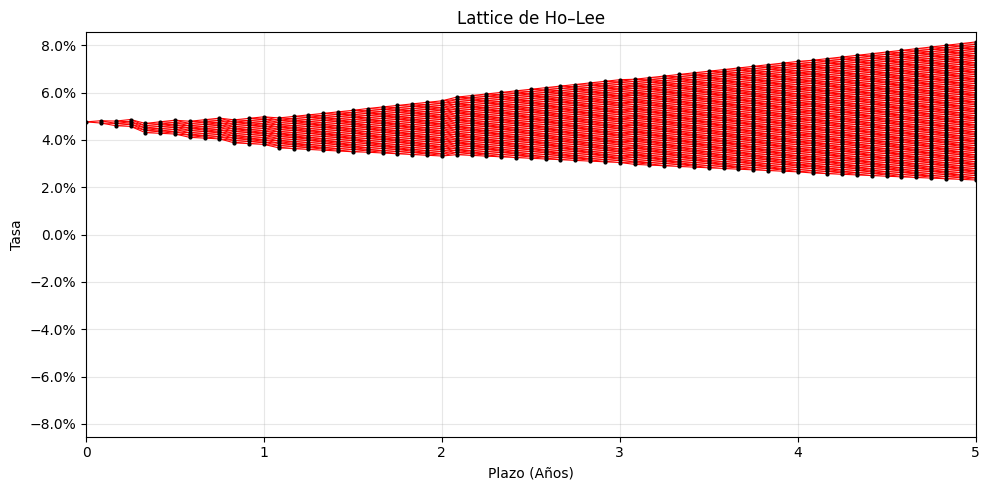

In [36]:
plot_ho_lee_lattice(r, dt)

In [50]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
def pascal_factors_funct(m: int) -> np.array:
    pascal_factors = np.zeros([m,m])
    for j in range(m):
        for i in range(m):
            if i == 0 or i==j:
                pascal_factors[i][j] = 1
            else:
                pascal_factors[i][j] = pascal_factors[i][j-1] + pascal_factors[i-1][j-1]
    return pascal_factors

def esperanza(m: int, r: np.array, pascal_factors: np.array) -> np.array:
    expected_value = np.zeros(m+1)
    for t in range(m+1):
        expected_value[t] = 2 ** (-t)*np.dot(r[:,t], pascal_factors[:,t])
    return expected_value

from matplotlib.ticker import PercentFormatter

def plot_ho_lee_lattice(
    r: np.ndarray,
    dt: float,
    sigma: float,
    title: str = "Lattice de Ho–Lee",
    mostrar_esperanza: bool = False
):
    """
    r : matriz triangular (n+1 x n+1) con r[i,j] definido para i<=j (NaN fuera)
        r en DECIMAL (p.ej. 0.0184 = 1.84%)
    dt : tamaño del paso en años (ej: 1/12 si mensuales, 0.25 si trimestrales)
    sigma : volatilidad anual (decimal)
    mostrar_esperanza : si True, traza E[r_t] usando pascal_factors_funct y esperanza
                        (deben existir en el namespace)
    """
    n = r.shape[0] - 1
    T = np.arange(n + 1) * dt  # eje en años

    fig, ax = plt.subplots(figsize=(10, 5))

    # --- aristas del lattice ---
    for j in range(n):
        for i in range(j + 1):
            if np.isfinite(r[i, j]) and np.isfinite(r[i, j+1]):
                ax.plot([T[j], T[j+1]], [r[i, j], r[i, j+1]], color="red", lw=0.8)
            if np.isfinite(r[i, j]) and np.isfinite(r[i+1, j+1]):
                ax.plot([T[j], T[j+1]], [r[i, j], r[i+1, j+1]], color="red", lw=0.8)

    # --- nodos ---
    for j in range(n + 1):
        y = r[:j+1, j]
        x = np.full(j + 1, T[j])
        ax.plot(x, y, "o", ms=2, color="black")

    # --- esperanza por tenor (opcional) ---
    if mostrar_esperanza:
        m = n  # nº total de pasos (meses si dt=1/12)
        # llamamos a TUS funciones (se asume que están definidas en tu entorno)
        pascal_factors = pascal_factors_funct(m+1)
        mu = esperanza(m, r, pascal_factors)  # vector de largo m+1
        ax.plot(T, mu, lw=2.2, color="blue", label="Valor esperado en plazo t")
        ax.legend(loc="upper left")

    # formato ejes
    ax.set_xlim(T[0], T[-1])
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # r en %
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Plazo (años)")
    ax.set_ylabel("Tasa")

    ax.set_title(f"{title} calibrado (NR) a mercado 15 septiembre de 2025 con volatilidad σ = {round(sigma*100*100,2)}bps")
    plt.savefig("holee_ewma.png", dpi=300, bbox_inches="tight", facecolor="white")
    plt.tight_layout()
    plt.show()

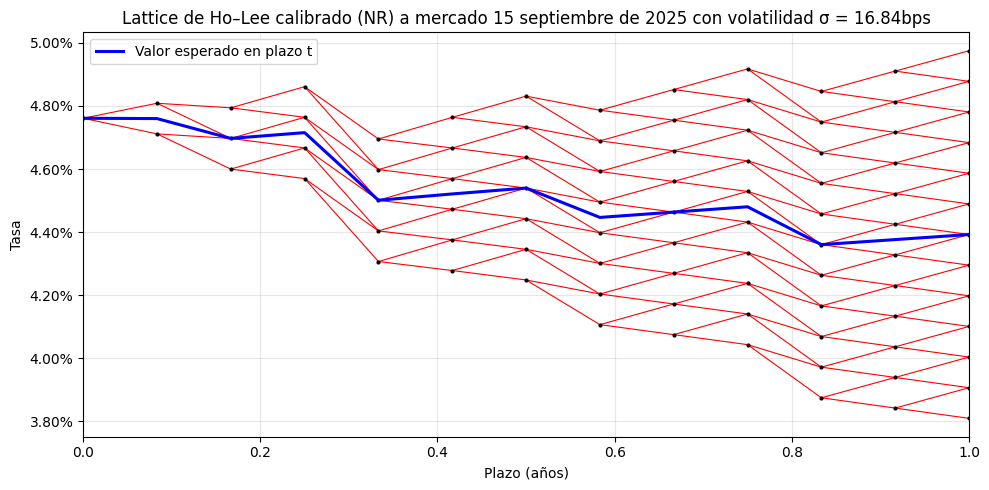

In [51]:
s = sigma
plot_ho_lee_lattice(r, dt=dt, sigma = s, mostrar_esperanza=True)

In [48]:
m = N
# llamamos a TUS funciones (se asume que están definidas en tu entorno)
pascal_factors = pascal_factors_funct(m+1)
mu_cal = esperanza(m, r, pascal_factors)  # vector de largo m+1
mu_exp = [0.04761   , 0.04750585, 0.04721558, 0.04715967, 0.0449756 ,
       0.04506966, 0.04534468, 0.04439575, 0.04454956, 0.04472099,
       0.04352258, 0.0436803 , 0.04384115, 0.04287206, 0.04302597,
       0.04318119, 0.04333743, 0.04349483, 0.04365338, 0.04394055,
       0.0441024 , 0.04426546, 0.04442975, 0.04459527, 0.04476204,
       0.04582336, 0.04599946, 0.04617694, 0.04635581, 0.04653608,
       0.04671776, 0.04690088, 0.04708546, 0.0472715 , 0.04745902,
       0.04764805, 0.04783861, 0.04754247, 0.04773221, 0.04792347,
       0.04811629, 0.04831066, 0.04850663, 0.04870419, 0.04890338,
       0.04910421, 0.0493067 , 0.04951088, 0.04971676, 0.04972402,
       0.0499317 , 0.05014112, 0.05035231, 0.05056528, 0.05078008,
       0.0509967 , 0.05121519, 0.05143555, 0.05165783, 0.05188203,
       0.05210819, 0.05144408, 0.05166646, 0.05189078, 0.05211705,
       0.05234531, 0.05257557, 0.05280786, 0.05304221, 0.05327866,
       0.05351721, 0.05375791, 0.05400078, 0.05424585, 0.05449315,
       0.05474271, 0.05499457, 0.05524874, 0.05550527, 0.05576419,
       0.05602553, 0.05628932, 0.0565556 , 0.0568244 , 0.05709577,
       0.05314725, 0.05338473, 0.05362434, 0.0538661 , 0.05411004,
       0.05435619, 0.05460458, 0.05485525, 0.05510821, 0.05536351,
       0.05562117, 0.05588123, 0.05614373, 0.05640869, 0.05667615,
       0.05694614, 0.05721871, 0.05749388, 0.0577717 , 0.0580522 ,
       0.05833543, 0.05862141, 0.0589102 , 0.05920183, 0.05949635,
       0.05979379, 0.0600942 , 0.06039763, 0.06070413, 0.06101372,
       0.06132648, 0.06164243, 0.06196164, 0.06228415, 0.06261002,
       0.06293929, 0.05641443, 0.05668193, 0.05695195, 0.05722455,
       0.05749974, 0.05777757, 0.05805808, 0.05834131, 0.05862729,
       0.05891607, 0.05920768, 0.05950217, 0.05979958, 0.06009995,
       0.06040334, 0.06070977, 0.06101931, 0.06133199, 0.06164787,
       0.06196699, 0.0622894 , 0.06261516, 0.06294432, 0.06327693,
       0.05503489, 0.05528941, 0.05554628, 0.05580551, 0.05606715,
       0.05633124, 0.05659779, 0.05686685, 0.05713846, 0.05741264,
       0.05768945, 0.0579689 , 0.05825105, 0.05853593, 0.05882357,
       0.05911403, 0.05940734, 0.05970355, 0.06000269, 0.06030482,
       0.06060997, 0.06091819, 0.06122953, 0.06154404, 0.06186175,
       0.06218274, 0.06250703, 0.06283469, 0.06316577, 0.06350032,
       0.0638384 , 0.06418006, 0.06452535, 0.06487435, 0.0652271 ,
       0.06558367, 0.04991544, 0.05012482, 0.05033593, 0.0505488 ,
       0.05076345, 0.0509799 , 0.05119817, 0.05141829, 0.05164028,
       0.05186416, 0.05208996, 0.05231771, 0.05254742, 0.05277912,
       0.05301284, 0.05324861, 0.05348645, 0.05372639, 0.05396846,
       0.05421268, 0.05445909, 0.05470771, 0.05495858, 0.05521172,
       0.05546716, 0.05572495, 0.0559851 , 0.05624766, 0.05651265,
       0.05678011, 0.05705008, 0.05732258, 0.05759766, 0.05787535,
       0.0581557 , 0.05843873, 0.05872449, 0.05901301, 0.05930434,
       0.05959852, 0.05989559, 0.06019559, 0.06049857, 0.06080457,
       0.06111364, 0.06142582, 0.06174115, 0.0620597 , 0.06238151,
       0.06270662, 0.0630351 , 0.06336699, 0.06370234, 0.06404121,
       0.06438366, 0.06472974, 0.06507952, 0.06543305, 0.06579038,
       0.0661516 , 0.04806039, 0.04825382, 0.04844878, 0.04864528,
       0.04884334, 0.04904299, 0.04924423, 0.04944709, 0.04965158,
       0.04985774, 0.05006557, 0.0502751 , 0.05048635, 0.05069935,
       0.0509141 , 0.05113064, 0.05134899, 0.05156916, 0.05179119,
       0.0520151 , 0.0522409 , 0.05246863, 0.05269831, 0.05292997,
       0.05316362, 0.0533993 , 0.05363704, 0.05387685, 0.05411877,
       0.05436283, 0.05460905, 0.05485746, 0.0551081 , 0.05536099,
       0.05561616, 0.05587364, 0.05613348, 0.05639569, 0.05666031,
       0.05692738, 0.05719692, 0.05746898, 0.05774359, 0.05802079,
       0.05830061, 0.05858309, 0.05886827, 0.05915618, 0.05944688,
       0.05974039, 0.06003676, 0.06033603, 0.06063825, 0.06094346,
       0.0612517 , 0.06156302, 0.06187746, 0.06219508, 0.06251592,
       0.06284004]



In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, PercentFormatter

# mu_exp y mu_cal: listas/arrays de largo 301 (incluye t=0)
n = len(mu_exp)
assert len(mu_cal) == n, "Las dos series deben tener el mismo largo"

# eje x en años
x_years = np.arange(n) / 12.0  # 0, 1/12, 2/12, ..., 300/12

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_years, mu_exp, label="Convención continua", lw=2)
ax.plot(x_years, mu_cal, label="Calibrado NR", lw=2, linestyle="--")

ax.set_xlabel("Plazo (años)")
ax.set_ylabel("Valor")  # cambia a "Tasa" si corresponde
ax.set_xlim(0, (n-1)/12)

# Ticks: mayor cada 1 año, menor cada 0.25 años
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))


# Si son tasas en DECIMAL, descomenta para ver %:
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=1))

ax.set_title("Esperanza por tenor del lattice de Ho-Lee, convención continua vs calibrado tasa simple (NR)")

ax.grid(True, which="both", alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


AssertionError: Las dos series deben tener el mismo largo

ValueError: x and y must have same first dimension, but have shapes (301,) and (61,)

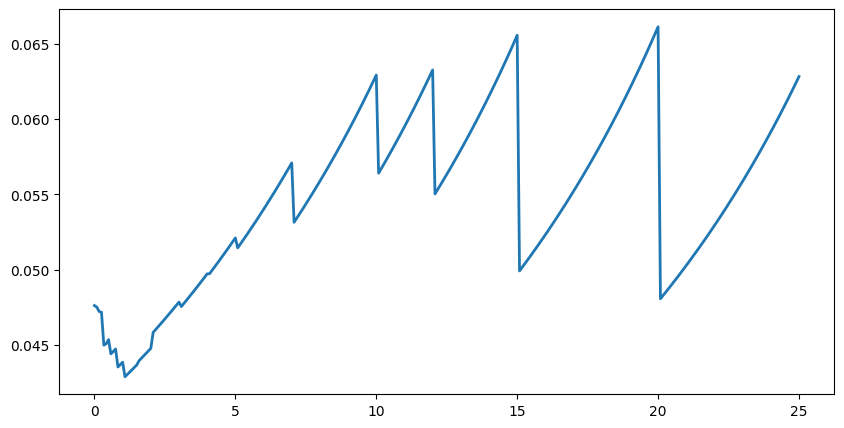

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, PercentFormatter

n = len(mu_exp)
x_years = np.arange(n) / 12.0

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_years, mu_exp, label="μ_exp", lw=2)
ax.plot(x_years, mu_cal, label="μ_cal", lw=2, ls="--")

ax.set_xlabel("Plazo (años)")
ax.set_ylabel("Tasa")
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

# <<< Aquí conviertes de decimal a porcentaje en los ticks >>>
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=1))
# (ajusta `decimals=` si quieres más/menos decimales)

ax.grid(True, which="both", alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


In [107]:
S = np.full((N+1, N+1), np.nan)
A = np.full((N+1, N+1), np.nan)
D = factores_descuento(r, dt)

nocional = 1_000_000
tasa = 5/100
bullet = True
timing = "pre"

credito = Credit(tasa, N, nocional, bullet)
C = coupons_from_credit(credito)
for i in range(N+1):
    S[i,N] = 0

for j in reversed(range(N)):
  for i in range(j+1):
    S[i,j] = D[i,j] * (0.5 * S[i, j+1] + 0.5*S[i+1, j+1] + C[j])

for i in range(0,N+1):
    A[i,N] = 0
for j in reversed(range(N)):
    for i in range(j+1):
        if timing == "pre":
            early = S[i,j] - (credito.nominal - credito.sum_amort[j])
        else:
            early = (S[i,j]- C[j]) - (credito.nominal - credito.sum_amort[j+1])
        cont = D[i,j] * 0.5 * (A[i, j+1] + A[i+1, j+1]) ## ACÁ HAY QUE MULTIPLICAR POR D[i,j]??
        print(early)
        print(cont)
        A[i,j] = max(early, cont)

bp = 1e-4  # 1 basis point en tasa anual (decimal)

# PV sin opción con la tasa actual del contrato
pv0 = pv_straight_given_rate(credito.ann_rate, r, dt)
# PV con +1 bp en la tasa del contrato
pv_up = pv_straight_given_rate(credito.ann_rate + bp, r, dt)

pv_per_bp = pv_up - pv0          # CLP por 1 bp en la tasa anual del contrato
bps_exact = A[0,0] / pv_per_bp   # bps que debes agregar

print("A00 (CLP):", A[0,0])
print("PV por 1bp:", pv_per_bp)
print("Spread necesario (bps):", bps_exact)

# Nueva tasa contractual:
new_annual_rate = credito.ann_rate + bps_exact * 1e-4
print("Tasa anual nueva:", round(new_annual_rate*100,3),"%")
print(A)
S

962.3661421857541
0.0
881.5539304178674
0.0
800.7547662662109
0.0
719.9686465710402
0.0
639.1955681736581
0.0
558.4355279164156
0.0
477.68852264259476
0.0
396.95454919699114
0.0
316.2336044248659
0.0
235.52568517264444
0.0
154.8307882876834
0.0
74.14891061862
0.0
1854.2327641972806
918.9931517167312
1692.8115887200693
838.3798081490073
1531.429476907826
757.792481690746
1370.0864161525387
677.2311628934071
1208.7823938516667
596.6958423125454
1047.517397407326
516.1865105077503
886.2914142269874
435.70315804287617
725.1044317237101
355.24577548580936
563.9564373149769
274.8143534082918
402.84741842304356
194.40888238615193
241.77736247587018
114.0293529993606
2562.5761141992407
1767.5672785982679
2320.8015164497774
1606.5778729440642
2079.10486806836
1445.6533755850398
1837.4861376226181
1284.7937582454315
1595.9452936935704
1123.9989926636474
1354.482304878533
963.2690505922061
1113.0971397899557
802.6039037981928
871.7897670557722
642.0035240627915
630.5601553183515
481.4678831808716

array([[1004356.50738582, 1004611.19324837, 1004786.6058178 ,
        1004830.25018423, 1004809.63705521, 1004529.13525812,
        1004184.12968394, 1003773.08197754, 1003202.06445918,
        1002562.5761142 , 1001854.2327642 , 1000962.36614219,
              0.        ],
       [             nan, 1003738.05707604, 1003990.99308626,
        1004112.62267394, 1004170.37846498, 1003968.73975011,
        1003702.92195373, 1003371.37325043, 1002880.1889404 ,
        1002320.80151645, 1001692.81158872, 1000881.55393042,
              0.        ],
       [             nan,              nan, 1003196.08188309,
        1003395.57086095, 1003531.58178851, 1003408.7044596 ,
        1003221.98508728, 1002969.85848932, 1002558.44303769,
        1002079.10486807, 1001531.42947691, 1000800.75476627,
              0.        ],
       [             nan,              nan,              nan,
        1002679.09423587, 1002893.24665406, 1002849.02912558,
        1002741.31891003, 1002568.53758481, 1002236

In [108]:
# Arreglar esta función (calibrar a factores de descuentos de la forward?¡)
def factores_descuento(r, dt): 
    return 1/(1 + dt * r)

# Cupones son el total del pago del mes o solo intereses?
def coupons_from_credit(cred: Credit):
    # C[j] = pago total del mes j (interés + amortización)
    return [cred.interests[j] + cred.amort[j] for j in range(cred.n_coupons)]

# No tomar en cuenta el timing post
def K_from_credit(cred: Credit, timing: str = "pre"):
    """
    Devuelve K[j] = capital pendiente del crédito según 'timing':
      - 'pre'  : antes de pagar la cuota del mes j  -> nominal - sum_amort[j]
      - 'post' : después de pagar la cuota del mes j -> nominal - sum_amort[j+1]
    """
    N = cred.n_coupons
    K = np.zeros(N, dtype=float)

    if timing == "pre":
        for j in range(N):
            K[j] = cred.nominal - cred.sum_amort[j]
    elif timing == "post":
        for j in range(N-1):
            K[j] = cred.nominal - cred.sum_amort[j+1]
    else:
        raise ValueError("timing debe ser 'pre' o 'post'")
    return K

class Credit:
    def __init__(self, ann_rate: float, n_coupons: int, nominal: float, bullet: bool):
        self.ann_rate = ann_rate
        self.eff_rate = self.ann_rate / 12.0      # tasa efectiva mensual (30/360)
        self.n_coupons = n_coupons
        self.nominal = nominal
        self.bullet = bullet

        self.coupon_value = 0.0
        self.interests = [0.0 for _ in range(self.n_coupons)]
        self.amort = [0.0 for _ in range(self.n_coupons)]
        self.sum_amort = [0.0 for _ in range(self.n_coupons + 1)]

        self.set_coupons()

    def set_coupons(self):
        m = self.eff_rate
        L = self.nominal
        N = self.n_coupons

        if self.bullet:
            # cupón mensual: sólo interés; al final se amortiza el capital completo
            self.coupon_value = m * L
            self.interests = [self.coupon_value for _ in range(N)]
            self.amort[-1] = L
            self.sum_amort[-1] = L
        else:
            # sistema francés (cuota fija mensual)
            self.coupon_value = L * (m * (1 + m)**N) / ((1 + m)**N - 1)
            for k in range(N):
                saldo = L - self.sum_amort[k]
                self.interests[k] = saldo * m
                self.amort[k] = self.coupon_value - self.interests[k]
                self.sum_amort[k + 1] = self.sum_amort[k] + self.amort[k]

def price_straight_tree(r: np.ndarray, alpha: np.ndarray, payments: np.ndarray) -> float:
    """
    Valora el crédito sin prepago.
    r: (n+1 x n+1) triangular (NaN fuera), r[i,j] en DECIMAL
    alpha: shape (n,), fracción de año del paso j->j+1
    payments: shape (n,), A_{j+1} pagado al final del paso j->j+1
    return: V_0 (valor hoy)
    """
    check_triangular(r)
    n = r.shape[0] - 1
    assert len(alpha) == n and len(payments) == n

    # Valor terminal post último pago: 0
    V_next = np.zeros(n+1)  # capa j=n (todos 0)

    # Backward: j = n-1, ..., 0
    for j in reversed(range(n)):
        V = np.zeros(j+1)
        for i in range(j+1):
            DF = discount_simple(r[i, j], alpha[j])
            cont = 0.5 * (V_next[i] + V_next[i+1]) + payments[j]  # EV bajo p=0.5
            V[i] = DF * cont
        V_next = V
    return float(V_next[0])
def tree_annuity_pv01(r: np.ndarray, alpha: np.ndarray, pay_idx: np.ndarray) -> float:
    """
    PV, bajo la misma medida, de pagar 1 unidad en cada fecha indicada por pay_idx.
    pay_idx: bool array shape (n,) -> True donde hay pago de 1
    Sirve para convertir el valor de la opción a 'bps' ≈ (Vstraight - Vcallable)/PV01 * 1e4
    """
    n = r.shape[0] - 1
    assert len(alpha) == n and len(pay_idx) == n
    unit_pay = np.where(pay_idx, 1.0, 0.0)
    return price_straight_tree(r, alpha, unit_pay)

def pv_straight_given_rate(annual_rate, r, dt):
    # Construye el calendario con ESA tasa
    cred = Credit(annual_rate, N, credito.nominal, credito.bullet)
    C_loc = [cred.interests[j] + cred.amort[j] for j in range(N)]
    # Backward del S_noPP con D ya consistente con r y dt
    S_loc = np.full((N+1, N+1), np.nan)
    for i in range(N+1):
        S_loc[i, N] = 0.0
    for j in range(N-1, -1, -1):
        for i in range(j+1):
            D_ij = 1.0 / (1.0 + dt * r[i, j])          # descuento simple
            cont = 0.5 * S_loc[i, j+1] + 0.5 * S_loc[i+1, j+1]
            S_loc[i, j] = D_ij * (cont + C_loc[j])
    return S_loc[0,0]


In [109]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from math import comb

def binomial_expectation(A: np.ndarray) -> np.ndarray:
    """
    Esperanza en cada tenor suponiendo prob. neutrales p=0.5 (binomial).
    A debe ser triangular: A[i,j] definido para i<=j.
    Devuelve vector mu de largo n+1 (n = A.shape[0]-1).
    """
    n = A.shape[0] - 1
    mu = np.zeros(n + 1)
    for j in range(n + 1):
        vals = A[:j+1, j]                 # valores en la columna j
        coefs = np.array([comb(j, i) for i in range(j+1)], dtype=float)
        mu[j] = np.sum(coefs * vals) / (2.0**j)
    return mu

def plot_option_lattice(
    A: np.ndarray,
    dt: float,
    title: str = "Árbol de precios de opción de prepago",
    principal: float | None = None,      # si se pasa, normaliza a % del capital
    show_expectation: bool = True,
    node_ms: float = 1.8,
    edge_lw: float = 0.6,
):
    """
    Dibuja (i) la malla del árbol de A y (ii) la esperanza por tenor.
    - A: matriz triangular (N+1 x N+1) con NaN fuera de i<=j
    - dt: paso en años (ej: 1/12 si mensual)
    - principal: si no es None, divide A y la esperanza por 'principal' para graficar en %
    """
    n = A.shape[0] - 1
    T = np.arange(n + 1) * dt  # eje X en años

    Y = A.copy()
    mu = binomial_expectation(A) if show_expectation else None

    if principal is not None:
        Y = Y / principal
        if mu is not None:
            mu = mu / principal

    fig, ax = plt.subplots(figsize=(9.5, 5.2))

    # --- aristas del lattice (malla roja) ---
    for j in range(n):
        for i in range(j + 1):
            if np.isfinite(Y[i, j]) and np.isfinite(Y[i, j+1]):
                ax.plot([T[j], T[j+1]], [Y[i, j], Y[i, j+1]], color="red", lw=edge_lw, alpha=0.9)
            if np.isfinite(Y[i, j]) and np.isfinite(Y[i+1, j+1]):
                ax.plot([T[j], T[j+1]], [Y[i, j], Y[i+1, j+1]], color="red", lw=edge_lw, alpha=0.9)

    # --- nodos (puntos) ---
    for j in range(n + 1):
        y = Y[:j+1, j]
        x = np.full(j + 1, T[j])
        ax.plot(x, y, "o", ms=node_ms, color="red", alpha=0.9)

    # --- esperanza (línea azul) ---
    if show_expectation:
        ax.plot(T, mu, color="tab:blue", lw=2.0, label="Costo Esperado")

    # Formato de ejes
    ax.set_xlabel("Plazo (años)")
    ax.set_ylabel("Costo Opción" if principal is None else "Costo Opción / Capital")
    ax.set_title(title)

    # Si normalizamos por principal, usar eje Y en %
    if principal is not None:
        ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=1))
        ax.set_ylim(bottom=0)

    ax.grid(True, alpha=0.25)
    if show_expectation:
        ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

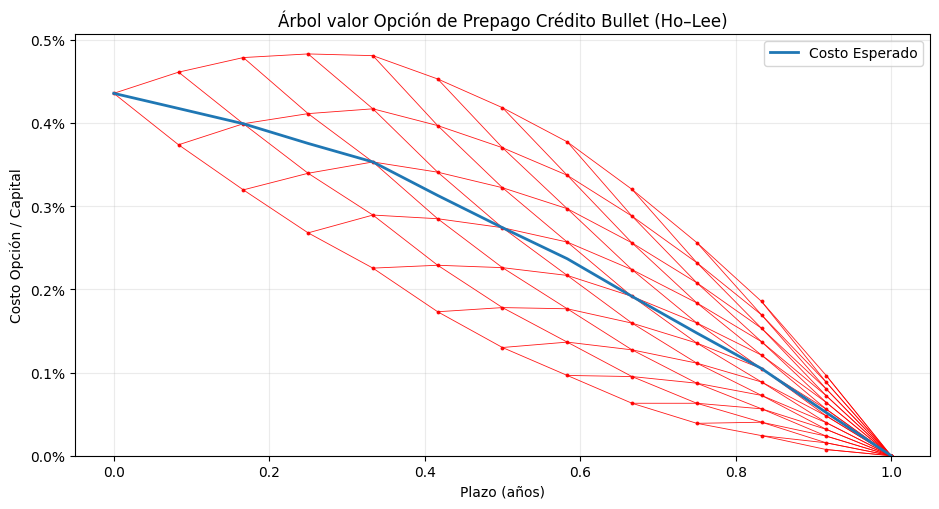

In [110]:
principal = nocional

if bullet:
    titulo = "Árbol valor Opción de Prepago Crédito Bullet (Ho–Lee)"
else:
    titulo = "Árbol valor Opción de Prepago Crédito Cuotas Iguales (Ho–Lee)"

plot_option_lattice(
    A,
    dt=dt,
    title=titulo,
    principal=principal,        # para que el eje Y sea %
    show_expectation=True
)


In [25]:
credito.coupon_value 

18871.233644010987

In [ ]:
credito.sum_amort

[0.0,
 14704.566977344319,
 29470.402983760905,
 44297.7633068709,
 59186.904297993846,
 74138.0833765798,
 89151.55903465988,
 104227.59084131528,
 119366.43944716507,
 134568.36658887257,
 149833.6350936705,
 165162.50888390513,
 180555.25298159907,
 196012.1335130334,
 211533.4177133487,
 227119.3739311653,
 242770.2716332228,
 258486.38140903888,
 274267.9749755875,
 290115.3251819968,
 306028.7060142661,
 322008.3926000032,
 338054.66121318087,
 354167.78927891346,
 370348.0553782533,
 386595.739253007,
 402911.12181057216,
 419294.48512879387,
 435746.1124608415,
 452266.28824010596,
 468855.29808511736,
 485513.42880448303,
 502240.968401846,
 519038.2060808647,
 535905.4322502126,
 552842.9385285996,
 569851.017749813,
 586929.9639677816,
 604080.0724616584,
 621301.6397409263,
 638594.9635505246,
 655960.342875996,
 673398.077948657,
 690908.4702507873,
 708491.8225208432,
 726148.4387586911,
 743878.6242308633,
 761682.6854758362,
 779560.9303093298,
 797513.6678296296,
 8155

In [27]:
K_from_credit(credito, "post")

array([985295.43302266, 970529.59701624, 955702.23669313, 940813.09570201,
       925861.91662342, 910848.44096534, 895772.40915868, 880633.56055283,
       865431.63341113, 850166.36490633, 834837.49111609, 819444.7470184 ,
       803987.86648697, 788466.58228665, 772880.62606883, 757229.72836678,
       741513.61859096, 725732.02502441, 709884.674818  , 693971.29398573,
       677991.6074    , 661945.33878682, 645832.21072109, 629651.94462175,
       613404.26074699, 597088.87818943, 580705.51487121, 564253.88753916,
       547733.71175989, 531144.70191488, 514486.57119552, 497759.03159815,
       480961.79391914, 464094.56774979, 447157.0614714 , 430148.98225019,
       413070.03603222, 395919.92753834, 378698.36025907, 361405.03644948,
       344039.657124  , 326601.92205134, 309091.52974921, 291508.17747916,
       273851.56124131, 256121.37576914, 238317.31452416, 220439.06969067,
       202486.33217037, 184458.79157707, 166356.1362313 , 148178.05315492,
       129924.22806572, 1